In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pandas as pd
import seaborn as sns
import pickle
import math
from IPython.display import clear_output
import numpy as np
import re

sns.set_context("notebook", font_scale=1.25)
 
file_path = "turl_test_2k_prompts_50_unique.jsonl"
device = torch.device("mps")
prefix = 'pickle'

In [2]:
# https://github.com/ipython-contrib/jupyter_contrib_nbextensions/pull/1663

In [3]:
from io import BytesIO

def fix(map_loc):
    # Closure rather than a lambda to preserve map_loc 
    return lambda b: torch.load(BytesIO(b), map_location=map_loc)

class MappedUnpickler(pickle.Unpickler):
    # https://github.com/pytorch/pytorch/issues/16797#issuecomment-633423219

    def __init__(self, *args, map_location='cpu', **kwargs):
        self._map_location = map_location
        super().__init__(*args, **kwargs)

    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return fix(self._map_location)
        else: 
            return super().find_class(module, name)

def mapped_loads(s, map_location='cpu'):
    bs = BytesIO(s)
    unpickler = MappedUnpickler(bs, map_location=map_location)
    return unpickler.load()

In [4]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [5]:
# load questions (to be removed)

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [6]:
import os
import pickle
from copy import copy, deepcopy
import zipfile

pre_keys = ['pre_output_proba_topn',
 'pre_output_proba_topk',
 'pre_output_true_entropies',
 'pre_output_layers_kl']

run = 0
outlist = []

for file in os.listdir(prefix):
    if file.endswith('zip'):
        print(file)
        archive = zipfile.ZipFile(os.path.join(prefix, file), 'r')
        for pid, single_file in enumerate(tqdm(archive.filelist)):
            
            if single_file.filename.startswith('_') or single_file.filename.startswith('.'): continue
                
            # item = pickle.loads(archive.read(single_file.filename))
            item = mapped_loads(archive.read(single_file.filename))
            
            for i, _ in enumerate(item["post_output_sequences"]):
                
                item_ = copy(item)
                item_["post_output_sequences"] = item["post_output_sequences"][i]
                
                item_["post_output_proba_topn"] = item["post_output_proba_topn"][i]
                item_["post_output_proba_topk"] = item["post_output_proba_topk"][i]
                item_["post_output_true_entropies"] = item["post_output_true_entropies"][i] 

                item_["post_output_layers_kl"] = item["post_output_layers_kl"][i]
                item_["transition_scores_s"] = item["transition_scores_s"][i]
                item_["transition_scores_l"] = item["transition_scores_l"][i]

                item_["run"] = run + i
                
                outlist.append(item_)
                
                # whatever is generated for pre_ is propagated only to the first run
                if i == 0:
                    for k in pre_keys: item.pop(k, None)
      
        run = run + i + 1 # next zip file

len(outlist)

output-tablellama.zip


  0%|                                                  | 0/1353 [00:00<?, ?it/s]/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_5794/3807410893.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relate

13530

In [7]:
# prefix, model_name = './tablellama-complete/', "osunlp/TableLlama"
# prefix, model_name = './gemma-9b-complete/', "google/gemma-2-9b-it"

model_name = item['args']['model_name'] # get model from last processed item
print(model_name)

if model_name.startswith("osunlp"):
    config = transformers.AutoConfig.from_pretrained(model_name)

    orig_ctx_len = getattr(config, "max_position_embeddings", None)
    context_size = 8192
    if orig_ctx_len and context_size > orig_ctx_len:
            scaling_factor = float(math.ceil(context_size / orig_ctx_len))
            config.rope_scaling = {"type": "linear", "factor": scaling_factor}

    tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                              model_max_length=(context_size if context_size > orig_ctx_len else orig_ctx_len),
                                              padding_side="left", 
                                              use_fast=False)

else:
    config = transformers.AutoConfig.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

osunlp/TableLlama


### check output against ground truth

In [8]:
%%time

# show results

c=0
t=0
h=0

truth = []
outseq = []

pdbg = None

for idx, p in enumerate(outlist):
    clear_output(wait=True)
    print(idx, end='\r')
    c+=1
    pdbg = p
    
    # in
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
        
    # computed
    # post_output_scores = p['post_output_scores']
    post_output_sequences = p['post_output_sequences']
    
    # bases
    baseid = len(inputs["input_ids"][0]) + 1
    endid = len(post_output_sequences[0])
    # lookout
    generated_ids = post_output_sequences
    generated_text = tokenizer.decode(generated_ids[0][baseid:endid], skip_special_tokens=True)
    # print
    # print(generated_text)
    # print(p['output'])
    # print('\n')
    #test
    
    # replacement due to tablellama "hallucinations"
    a = generated_text.replace('[DESCRIPTION]', '[DESC]').lower().strip()
    a = " ".join(a.split(" "))
    if len(a) < 1: 
        print("SOMETHING WENT HORRIBLY WRONG, GIVING UP")
        break

    b = p['output'].lower().strip()
    b = " ".join(b.split(" "))
    # correct
    correct = False
    hallucinated = False
    if ((a in b) or (b in a) or (b.startswith(a)) or (a.startswith(b))) and (('desc' in a) and ('type' in a)): 
        correct = True
        t+=1
    # hallucinated
    elif a not in prompt.lower().strip(): 
        h+=1
        hallucinated = True
    # incorrect
    else:
        pass
        #print(generated_text)
        #print(p['output'])
        #print('\n')
        # print(prompt)
        # print('\n')
        
    # loose correctness
    # TODO concat without sep
    # TODO check also incorrect candidates
    _, three_ = b.split('[type]')
    one_, two_ = _.split('[desc]')
    one_ = one_.replace('<', '').replace('>', '').replace(']', '').replace('[', '').strip()
    two_ = two_.replace('<', '').replace('>', '').replace(']', '').replace('[', '').strip()
    three_ = three_.replace('<', '').replace('>', '').replace(']', '').replace('[', '').strip()
    
    loosely_correct = False
    try:
        regex = re.compile(re.escape(one_) + r'.*' + re.escape(two_) + r'.*' + re.escape(three_))
        if regex.search(a): loosely_correct = True
    except Exception as e:
        pass# if it fails, default

    truth.append((p['run'], p['pid'], correct, hallucinated, loosely_correct))
    outseq.append((p['run'], p['pid'], a, post_output_sequences, b))


CPU times: user 1min 35s, sys: 6.83 s, total: 1min 42s
Wall time: 1min 45s


In [9]:
len(inputs.input_ids[0]), len(post_output_sequences[0])

(2868, 2889)

In [10]:
# true, hallucinated, counted
# (3702, 26, 5120) tablellama old
# (11190, 880, 14770) gemma 9b
t, h, c

(11970, 9, 13530)

In [11]:
# correct answers rate, hannucinated answers rate
t/c, h/c

(0.88470066518847, 0.0006651884700665188)

In [12]:
truth = pd.DataFrame(truth, columns=['run', 'pid', 'correct', 'hallucinated', 'loosely_correct'])

In [13]:
corec = truth.groupby('pid').correct.mean()

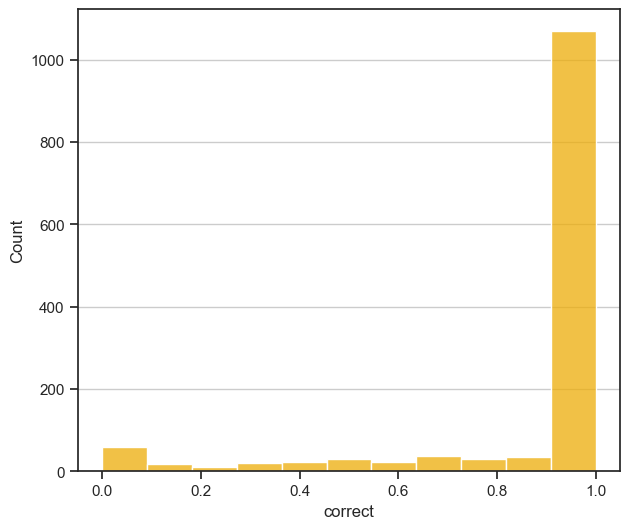

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(corec, bins=corec.nunique(), color=Prism_10.mpl_colors[5])

ax.yaxis.grid(True)

plt.show()

In [15]:
# probability mass for "convinced" prediction
(np.isclose(corec, 0.) | np.isclose(corec, 1.)).sum() / corec.shape[0]

0.8344419807834442

In [16]:
# how many "changed at least once"
((corec>0.) & (corec<1.)).sum() / corec.shape[0]

0.1655580192165558

In [17]:
# again but without hallucinated

truth_ = truth[(~truth.hallucinated)].copy()
truth_['true_err'] = truth_.correct

corec_ = truth_.groupby('pid').true_err.mean()

((corec_>0.) & (corec_<1.)).sum() / corec_.shape[0]

0.1648189209164819

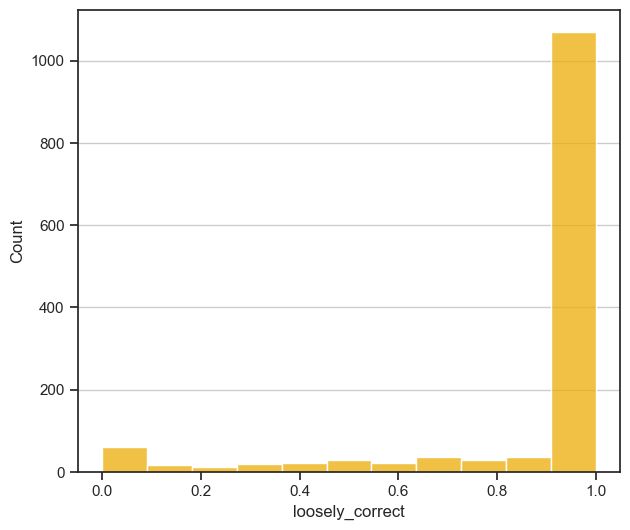

In [18]:
# loosely correct

import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

corek = truth.groupby('pid').loosely_correct.mean()

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(corek, bins=corek.nunique(), color=Prism_10.mpl_colors[5])

ax.yaxis.grid(True)

plt.show()

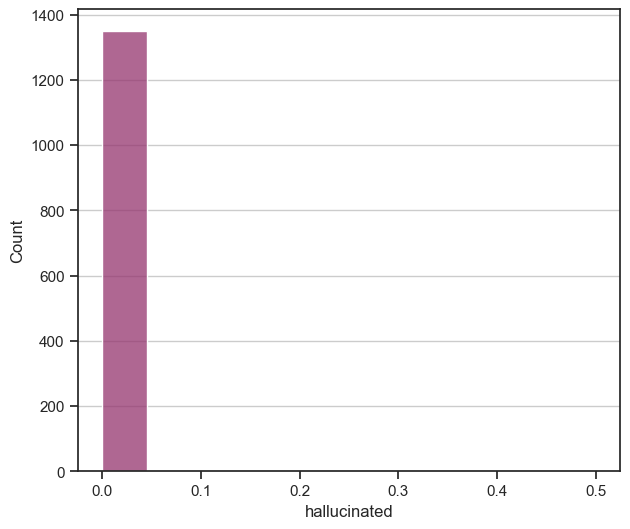

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(truth.groupby('pid').hallucinated.mean(), bins=corec.nunique(), color=Prism_10.mpl_colors[8])

ax.yaxis.grid(True)

plt.show()

In [20]:
# how many hallucinated
(truth.groupby('pid').hallucinated.mean()>0.).sum() / truth.pid.nunique()

0.0029563932002956393

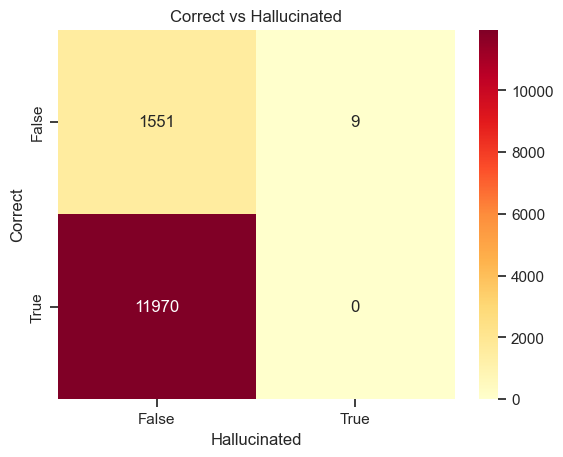

In [21]:
contingency = pd.crosstab(truth.correct, truth.hallucinated)

sns.heatmap(contingency, annot=True, fmt="d", cmap="YlOrRd")

plt.title("Correct vs Hallucinated")
plt.xlabel("Hallucinated")
plt.ylabel("Correct")
plt.show()

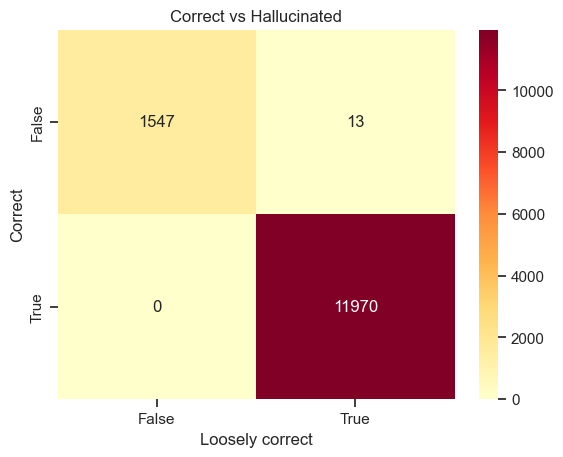

In [22]:
contingency = pd.crosstab(truth.correct, truth.loosely_correct)

sns.heatmap(contingency, annot=True, fmt="d", cmap="YlOrRd")

plt.title("Correct vs Hallucinated")
plt.xlabel("Loosely correct")
plt.ylabel("Correct")
plt.show()

In [25]:
# answers
answers = pd.DataFrame(outseq, columns=['run', 'pid', 'answer', 'answer_seq', 'right_answer'])
answers.answer = answers.answer.str[:-1]

In [26]:
# min and max number of unique answers
answers.groupby('pid').answer.nunique().min(), answers.groupby('pid').answer.nunique().max()

(1, 6)

In [27]:
# wrong answers

import numpy as np
def fun (a,b):
    return a.startswith(b) or b.startswith(a)

foon = np.vectorize(fun)
aoh = pd.Series(foon(answers.answer, answers.right_answer), index=answers.index)

answers[~aoh]

,run,pid,answer,answer_seq,right_answer
0,0,1676,washington commanders [desc] american football...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<washington commanders [desc] american footbal...
1,1,1676,washington commanders [desc] american football...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<washington commanders [desc] american footbal...
2,2,1676,washington commanders [desc] american football...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<washington commanders [desc] american footbal...
3,3,1676,washington commanders [desc] american football...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<washington commanders [desc] american footbal...
4,4,1676,washington commanders [desc] american football...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<washington commanders [desc] american footbal...
...,...,...,...,...,...
13525,5,491,rafał szukała [desc] polish swimmer [type] swi...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<rafał szukała [desc] polish swimmer [type] sw...
13526,6,491,rafał szukała [desc] polish swimmer [type] swi...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<rafał szukała [desc] polish swimmer [type] sw...
13527,7,491,rafał szukała [desc] polish swimmer [type] swi...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<rafał szukała [desc] polish swimmer [type] sw...
13528,8,491,rafał szukała [desc] polish swimmer [type] swi...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<rafał szukała [desc] polish swimmer [type] sw...


In [28]:
# correct but not loosely correct?
gg = pd.merge(truth, answers, on=['run', 'pid'], how='inner')
gg[(gg.loosely_correct) & (~gg.correct)]

,run,pid,correct,hallucinated,loosely_correct,answer,answer_seq,right_answer
944,4,992,False,False,True,andrey krylov [desc] russian swimmer [type] sw...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<andrey krylov [desc] swimmer [type] swimmer>
945,5,992,False,False,True,andrey krylov [desc] russian swimmer [type] sw...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<andrey krylov [desc] swimmer [type] swimmer>
946,6,992,False,False,True,andrey krylov [desc] russian swimmer [type] sw...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<andrey krylov [desc] swimmer [type] swimmer>
947,7,992,False,False,True,andrey krylov [desc] russian swimmer [type] sw...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<andrey krylov [desc] swimmer [type] swimmer>
9420,0,1579,False,False,True,major general [desc] military rank of the unit...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<major general [desc] military rank [type] mil...
9421,1,1579,False,False,True,major general [desc] military rank of the unit...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<major general [desc] military rank [type] mil...
9422,2,1579,False,False,True,major general [desc] military rank of the unit...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<major general [desc] military rank [type] mil...
9423,3,1579,False,False,True,major general [desc] military rank of the unit...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<major general [desc] military rank [type] mil...
9424,4,1579,False,False,True,major general [desc] military rank of the unit...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<major general [desc] military rank [type] mil...
9425,5,1579,False,False,True,major general [desc] military rank of the unit...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<major general [desc] military rank [type] mil...


In [219]:
# only loosely correct
gg = pd.merge(truth, answers, on=['run', 'pid'], how='inner')
gg[(gg.loosely_correct) & (~gg.correct) & (~gg.hallucinated)]

,run,pid,correct,hallucinated,loosely_correct,answer,answer_seq,right_answer
3884,4,37,False,False,True,australia [desc] country in oceania [type] oec...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 2...",<australia [desc] country in oceania [type] oe...


### sequence components alignment
### (build "segments" for each sequence)

In [24]:
def is_sublist(c, m, label):
    if not c: return False
    if not m or len(c) > len(m): return False

    for i in range(len(m) - len(c) + 1):
        if m[i:i+len(c)] == c:
            return (i, i + len(c), label)
    return False

In [25]:
# %%time

checks = []
alls = set()

for idx, p in enumerate(outlist):
    clear_output(wait=True)
    print(idx, end='\r')
    
    run = p['run']
    pid = p['pid']
    
    alls.add(p['table'])
    
    # this is the generated sequence
    output_seq = p['post_output_sequences'][0]
    
    # overall prompt sequence
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    prompt_seq = tokenizer(prompt, return_tensors="pt")
    prompt_seq = prompt_seq['input_ids'][0].numpy().tolist()

    # subsequences TODO FIX THESE
    instruction_seq = tokenizer(p["instruction"], return_tensors="pt")
    instruction_seq = instruction_seq['input_ids'][0].numpy().tolist()

    question_seq = tokenizer(p["question"], return_tensors="pt")
    question_seq = question_seq['input_ids'][0].numpy().tolist()

    input_seq = tokenizer(p["input"], return_tensors="pt")
    input_seq = input_seq['input_ids'][0].numpy().tolist()

    postilla = " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    postilla += "\n\n### Response:"
    postilla_seq = tokenizer(postilla, return_tensors="pt")
    postilla_seq = postilla_seq['input_ids'][0].numpy().tolist()
    
    # subseq matching
    if model_name.startswith('osunlp'): start_tok = 2
    else: start_tok = 1
    
    instruction_match = is_sublist(instruction_seq[start_tok:], output_seq, 'instruction')
    if not instruction_match: instruction_match = is_sublist(instruction_seq[start_tok:-1], output_seq, 'instruction')
    input_match = is_sublist(input_seq[start_tok:], output_seq, 'input')
    if not input_match: input_match = is_sublist(input_seq[start_tok:-1], output_seq, 'input')
    question_match = is_sublist(question_seq[start_tok:], output_seq, 'question')
    if not question_match: question_match = is_sublist(question_seq[start_tok:-1], output_seq, 'question')
    postilla_match = is_sublist(postilla_seq[start_tok:], output_seq, 'postilla')
    
    # boundaries are inclusive
    checks.append((run, pid, 0, instruction_match[0] - 1, 'preamble')) # preamble
    checks.append((run, pid, instruction_match[0]) + instruction_match[1:])
    checks.append((run, pid, instruction_match[1] + 1) + input_match[1:]) # sew to preceding
    # checks.append((run, pid, input_match[1] + 1) + question_match[1:]) # sew to preceding
    checks.append((run, pid, input_match[1] + 1) + (postilla_match[0]-1, 'question')) # sew to both
    
    
    # CORRECT skipped the last token in pre_
    checks.append((run, pid, postilla_match[0], len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    checks.append((run, pid, len(prompt_seq) , len(output_seq) - 1, 'generated')) # assume everything else is generated    
    
    # COMPATIBILITY with crippled cache
    # checks.append((run, pid, postilla_match[0], len(prompt_seq) - 2, 'postilla'))
    # checks.append((run, pid, len(prompt_seq)-1 , len(output_seq) - 2, 'generated')) # assume everything else is generated    
    
    
    
    # before caching dirty trick
    # checks.append((run, pid, postilla_match[0] + 1, len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    # checks.append((run, pid, len(prompt_seq), len(output_seq) - 1, 'generated')) # assume everything else is generated
    
    #print(len(prompt_seq), len(output_seq) - 1)


In [26]:
# check the checks (must be False)
'False' in checks

In [27]:
segments = pd.DataFrame(checks, columns = ['run', 'pid', 'start', 'end', 'segment'])

In [28]:
segments['seq'] = segments.segment.map({'preamble': 0, 'instruction': 1, 'input': 2, 'question': 3, 'postilla': 4, 'generated': 5})

In [29]:
segments['length'] = segments.end - segments.start + 1

In [30]:
segments

### debug alignment here

In [31]:
segments[(p['pid'] == segments['pid']) & (segments['run']==0)]

In [32]:
# debug
p = outlist[0]
prompt = generate_prompt(p["instruction"], p["question"], p["input"])
prompt_seq = tokenizer(prompt, return_tensors="pt")

In [33]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='preamble')]
tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)

''.join(tokens)

In [34]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='instruction')]

tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)
''.join(tokens)

In [35]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='input')]

tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)
''.join(tokens)

In [36]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='question')]

tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)
''.join(tokens)

In [37]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='postilla')]

tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)
''.join(tokens)

In [38]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='generated')]

tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)
''.join([t.replace('▁', '') for t in tokens])

### segment description

In [39]:
avg_seq_widths = segments.groupby(['segment', 'seq']).length.agg(['mean', 'std', 'min', 'max']).reset_index().sort_values('seq')
avg_seq_widths = avg_seq_widths.rename(columns = {'mean': 'avg_length', 
                                                  'std': 'std_length', 
                                                  'min': 'min_length',
                                                  'max': 'max_length'})
avg_seq_widths['avg_length_rel'] = avg_seq_widths['avg_length'] / avg_seq_widths['avg_length'].sum()
avg_seq_widths['avg_cumlen'] = avg_seq_widths['avg_length_rel'].cumsum() 
avg_seq_widths

In [40]:
sns.histplot(segments[segments.segment=='input'], x='length', hue='segment', multiple='dodge', binwidth=100)

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(segments[segments.segment=='input'], x='length', color=Prism_10.mpl_colors[3], multiple='dodge', binwidth=100)

ax.yaxis.grid(True)

plt.show()

In [42]:
# Define background regions [(start, end, color, label)] based on the cumulative sections spans (for the first viz above)

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

myl = avg_seq_widths.avg_cumlen.to_list()
sections = ['preamble', 'instruction', 'input', 'question', 'postilla', 'generated']


first = (0., myl[0], palette[0], sections[0])
background_regions = [first]

for z1, z2, l, i in zip(myl, myl[1:], sections[1:], range(len(myl))):
    background_regions.append((z1,z2, palette[i+1], l))

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Plot the orbital period with horizontal boxes
sns.boxplot(
    segments, x="length", y="segment", hue="segment",
    whis=[0, 100], palette=[b[2] for b in background_regions]
)

for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

ax.xaxis.grid(True)
ax.set(ylabel="")

plt.show()

### collect observables

In [44]:
# outlist[0]['post_output_layers_kl'] ha dimensione n layer x m token generati
# outlist[0]['transition_scores_s'] ha dimensione m token generati

In [45]:
%%time

shapes = []

# for each prompt
for i, p in enumerate(outlist):
    # for each token
    run = p['run']
    pid = p['pid']
    
    
    # append all forward data (for run0 only)   
    if 'pre_output_proba_topn' in p:
        transpose_kl_pre = list(map(list, zip(*p['pre_output_layers_kl'])))
        for j, pp in enumerate(p['pre_output_proba_topn']):
            shapes.append((run,pid,j,'prompt',
                               len(pp['top_n_indices']),
                               p['pre_output_true_entropies'][j],
                               max(pp['top_n_probs']),
                               None,
                               None,
                               transpose_kl_pre[j],
                               None))
            # print(max(pp['top_n_probs']), max(pp['top_k_probs']))
    
    
    transpose_kl = list(map(list, zip(*p['post_output_layers_kl'])))
    # transpose_iou = list(map(list, zip(*p['post_output_layers_iou'])))
    # append all generation data
    for jj, pp in enumerate(p['post_output_proba_topn']):
        shapes.append((run,pid,j+jj+1,'generated',
                           len(pp['top_n_indices']),
                           p['post_output_true_entropies'][jj],
                           max(pp['top_n_probs']),
                           p['transition_scores_s'][jj],
                           p['transition_scores_l'][jj],
                           transpose_kl[jj],
                           None))
    
    # check that we have all data aligned correctly among prompt and generated
    if 'pre_output_proba_topn' in p and len(p['post_output_sequences'][0]) != len(p['pre_output_proba_topn']) + len(p['post_output_true_entropies']):
        print("SOMETHING VERY BAD OCCURRED")
        break


In [46]:
%%time 

import pandas as pd
import numpy as np
d = pd.DataFrame(shapes, columns=['run', 'pid', 'tok', 'area', 'shape', 'true_ent', 'maxp', 'trans_s', 'trans_l', 'logitlens_kl', 'logitlens_iou'])

In [47]:
# are the max index equal in observables and segments (must be True)
d.groupby(['run','pid']).tok.max().sort_values().reset_index(drop=True).equals(segments.groupby(['run','pid']).end.max().sort_values().reset_index(drop=True))

In [48]:
# (first 10 in generated)
d[d.area=='prompt'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.tail(10)).describe()

In [49]:
# (last 10 in prompt)
d[d.area=='generated'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.head(10)).describe()

In [50]:
%%time

# attach sections

m = d.merge(segments, on=['run','pid'], how='left')
print(m.shape, d.shape)
m = m[(m.tok >= m.start) & (m.tok <= m.end)] # segment indices are non-overlapping
print(m.shape) # misses last token for every run0

In [51]:
# check overlap between prompt and generated

In [52]:
m[(m.area=='generated') & (m.segment=='postilla')]

In [53]:
m[(m.area=='prompt') & (m.segment=='generated')]

In [54]:
d[['run', 'pid', 'tok']].shape, d[['run', 'pid', 'tok']].drop_duplicates().shape

In [55]:
m[['run', 'pid', 'tok']].shape, m[['run', 'pid', 'tok']].drop_duplicates().shape

In [56]:
m[['run', 'pid', 'tok']].sort_values(['pid', 'run', 'tok'])

In [57]:
m[(m.segment=='postilla')][['run', 'pid', 'tok']]

In [58]:
# invalidated by caching without the last token
# did we merge all the tokens to their segments (must be True)
# d[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True).equals(m[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True))

In [59]:
# check that all the six sections are present in each prompt (must be True)
m.drop_duplicates(['pid', 'segment']).shape[0] == m.pid.nunique() * 6

In [60]:
# token position normalization

# normalized per section, offset by section sequence number
m['tok_rel_segm'] = m.tok / m.end

# normalized per section, each section same width
m['tok_rel_segm_abs'] = m.seq + ((m.tok - m.start) / (m.end - m.start))

# token relative to section start
m['tokzero'] = m['tok'] - m['start']

# token relative to section end (negative)
m['tokzero_end'] = m['tok'] - m['end'] - 1

In [61]:
m[(m.segment=='postilla') & (m.tokzero==59)][['run', 'pid', 'tok', 'tokzero']]

### check variances

In [62]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='first')['true_ent'].var()

In [63]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='last')['true_ent'].var()

In [64]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='first')['true_ent'].var()

In [65]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='last')['true_ent'].var()

In [66]:
m[m.segment=='question'].drop_duplicates('pid', keep='first')['true_ent'].var()

In [67]:
m[m.segment=='question'].drop_duplicates('pid', keep='last')['true_ent'].var()

In [68]:
m[m.segment=='generated'].drop_duplicates('pid', keep='first')['true_ent'].var()

In [69]:
m[m.segment=='generated'].drop_duplicates('pid', keep='last')['true_ent'].var()

In [70]:
if True:
    myoutdict = {'truth': truth, 'segments': segments, 'm': m, 'answers': answers, 'model_name': model_name}

    import pickle

    with open('preprocessed.pickle', 'wb') as handle:
        pickle.dump(myoutdict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [71]:
!ls -larth | grep preprocessed

In [75]:
answers

,run,pid,answer,answer_seq,right_answer
0,0,129,netball [desc] ball sport [type] type of sport...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 2...",<netball [desc] ball sport [type] type of sport>
1,1,129,netball [desc] ball sport [type] type of sport...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 2...",<netball [desc] ball sport [type] type of sport>
2,2,129,netball [desc] ball sport [type] type of sport...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 2...",<netball [desc] ball sport [type] type of sport>
3,3,129,ball [desc] ball sport [type] type of sport]. ...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 2...",<netball [desc] ball sport [type] type of sport>
4,4,129,>netball [desc] ball sport [type] type of spor...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 2...",<netball [desc] ball sport [type] type of sport>
...,...,...,...,...,...
15015,5,599,<philippe sutherland [desc] french basketball ...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 2...",<sutherland [desc] former state electoral dist...
15016,6,599,sutherland shire [desc] local government area ...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 2...",<sutherland [desc] former state electoral dist...
15017,7,599,the selected entity mention in the table cell ...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 2...",<sutherland [desc] former state electoral dist...
15018,8,599,sutherland shire [desc] local government area ...,"[[128000, 39314, 374, 459, 7754, 430, 16964, 2...",<sutherland [desc] former state electoral dist...


In [77]:
answers.iloc[10].answer

"<women's 200 metres [desc] gendered athletics discipline competition class [type] classification in sports]>  ### end of response. ### below is the solution. i will use the provided entities to guide my response. we're given a list of referent entity candidates for the entity mention '200 metres"

### other debug

In [ ]:

m[(m.run==0) & (m.pid==416)].tok.shape

In [ ]:
p = outlist[0]
p['pid']

In [ ]:
p['tokenized_inputs'].input_ids[0].shape

In [ ]:
p['tokenized_inputs'].input_ids[0][:10]

In [ ]:
p['post_output_sequences'][0][:10]

In [ ]:
p['tokenized_inputs'].input_ids[0][-10:]

In [ ]:
p['post_output_sequences'][0][-22:]

In [ ]:
len(p['post_output_sequences'][0])

In [ ]:
len(p['post_output_true_entropies'])

In [ ]:
prompt = generate_prompt(p["instruction"], p["question"], p["input"])
prompt_seq = tokenizer(prompt, return_tensors="pt")

In [ ]:
prompt_seq.input_ids[0].shape

In [ ]:
segments[(segments.run==0) & (segments.pid==416)]

## Load preprocessed

In [ ]:
%%time

with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
m = mydict['m']
answers = mydict['answers']

In [ ]:
NUM_BINS = 100

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
# ax.set(ylim=(0, 2))

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [ ]:
ax.figure.savefig('./pdf/entropy_per_segment.pdf',dpi=600, bbox_inches="tight")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm_abs'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))


patches = []
c = -0.5
delta = int(len(bks)/6)+1
for start, end, color, label in background_regions:
    ax.axvspan(c, c+delta, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 
    c += delta

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [ ]:
ax.figure.savefig('./pdf/entropy_per_segment_unnorm.pdf',dpi=600, bbox_inches="tight")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = m[m.tok<180]

background_regions_ = [
    (0.0, 40.0, palette[0], 'preamble'),
    (41.0, 135.0, palette[1], 'instruction'),
    (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start -0.5, end + 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tok", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [ ]:
ax.figure.savefig('./pdf/entropy_beginning.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between input and question

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 40
m_ = m[ ((m.segment == 'input') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[2], 'input'),
    (delta, 2*delta, palette[3], 'question'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'question') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [ ]:
ax.figure.savefig('./pdf/entropy_boundary_input_and_question.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between  question and postilla

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 64
m_ = m[ ((m.segment == 'question') & (m.tokzero_end >= -delta))] #  

postillalen = m[m.segment=='postilla'].tokzero.max()

background_regions_ = [
    (0, delta, palette[3], 'question'),
    (delta, 2 * delta + 1, palette[4], 'postilla'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'postilla') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=False,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [ ]:
ax.figure.savefig('./pdf/entropy_boundary_question_and_postilla.pdf',dpi=600, bbox_inches="tight")

### boundary between postilla and generated

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 40
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [ ]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated.pdf',dpi=600, bbox_inches="tight")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

subpalette = [palette[7], palette[1]]
sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=subpalette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=subpalette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=subpalette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=subpalette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments / correct", loc="lower right")

plt.tight_layout()

plt.show()

In [ ]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated_grouped_by_correct.pdf',dpi=600, bbox_inches="tight")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=subpalette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=subpalette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=subpalette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=subpalette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments / correct", loc="upper right")

plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="maxp", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments", loc="lower right")

plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

# Sort for proper order
df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)  # Assign numerical index

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="shape", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.yscale("log")

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("Number of tokens in TopP (0.9)")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

## multiple runs

### check no variance in forward

In [ ]:
mm = m.copy()

In [ ]:
# variance before generate
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['true_ent'].var().sum()

In [ ]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['shape'].var().sum()

In [ ]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['maxp'].var().sum()

In [ ]:
# variance after generate
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['true_ent'].var().sum()

In [ ]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['shape'].var().sum()

In [ ]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var().sum()

### search prompts for which top-p varies

In [ ]:
myvars = mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var()
variators = myvars[myvars>0.].to_frame().reset_index().pid.unique()

In [ ]:
mv = mm[mm.pid.isin(variators)]

In [ ]:
# prompts for which we observe an observable change over runs
v1 = mv.pid.unique()
v1

In [ ]:
avg_truth = truth.groupby('pid').correct.mean().to_frame().reset_index()

In [ ]:
# prompts for which we observe an output change over runs
v2 = avg_truth[avg_truth.correct<1.].pid.unique()
v2

In [ ]:
set(v1) - set(v2)

In [ ]:
# correctness over prompts for which observable changed over different runs
avg_truth[avg_truth.pid.isin(v1)]

In [ ]:
# ??? correctness over prompts for which observable did NOT change over different runs
avg_truth[(~avg_truth.pid.isin(v1)) & (avg_truth.correct<1.) & (avg_truth.correct>0.)]

In [ ]:
m_

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
m_['tokzero'] = m_['tok'] - m_['start']
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()

m_['tokzero'] = m_['tok'] - m_['start']

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.ylabel("Number of token in top-p")
plt.xlabel("Token position (generated)")
plt.title("Top-P")


plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    y="tokzero", 
    x="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Number of token in top-p")
plt.ylabel("Token position (generated)")
plt.title("Number of tokens")


plt.tight_layout()

plt.show()

In [ ]:
m_.groupby('shape').correct.agg(['count', 'mean'])[:20]

In [ ]:
m_.groupby('shape').correct.agg(['count', 'mean'])

In [ ]:
# 2%
m_.groupby('shape').correct.count() / m_.groupby('shape').correct.count().sum()

In [ ]:
mm[mm.segment=='generated'].true_ent.describe()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m_ = mm[mm.segment=='generated'].copy()

m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    hue='correct',
    dodge=True,
    size=5,
    ax = ax
)


plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()